In [22]:
import pandas as pd
from useful_functions import * 
from dpks.quant_matrix import QuantMatrix

In [80]:
df = pd.read_csv('../data/220316_ghost_nrt_filtered.tsv', sep='\t')
design_matrix = pd.read_csv('../data/design_matrix_group_de_early_time_points_subtypes.tsv', sep='\t')

GroupOneCols = design_matrix[design_matrix['Group'] == 1]['Sample'].values
GroupTwoCols = design_matrix[design_matrix['Group'] == 2]['Sample'].values

quant_matrix = QuantMatrix(
    quantification_file="../data/220316_ghost_nrt_filtered.tsv",
    design_matrix_file="../data/design_matrix_group_de_early_time_points_subtypes.tsv"
)

quantified_proteins = (
    quant_matrix
    .filter() # filter for q-values (removes rows with low q value (peptides), Q = 0.01) and removes decoys
    .normalize(method="mean", use_rt_sliding_window_filter = True) # best type of normalization is RT-sliding window
    .quantify(method="maxlfq") # play around with minimum_subgroups (default is set 1)
)

compare_df = quantified_proteins.compare_groups(
    method='linregress',
    group_a=1,
    group_b=2,
    min_samples_per_group = 2, # play around with this 
    level='protein',
    
).to_df()

df = compare_df.dropna(subset=['CorrectedPValue'])
df

Mean of empty slice


,Protein,Group1Mean,Group2Mean,Log2FoldChange1-2,PValues1-2,Group1RepCounts,Group2RepCounts,CorrectedPValue,TM_M2012_010,TM_M2012_011,...,TM_M2012_177,TM_M2012_178,TM_M2012_182,TM_M2012_183,TM_M2012_186,TM_M2012_188,TM_M2012_189,TM_M2012_196,TM_M2012_197,TM_M2012_198
0,P06396,21.288717,21.226708,0.062010,0.694861,30,42,0.721447,21.690603,20.691873,...,20.419413,21.028937,21.542064,21.509333,21.198022,21.245511,21.200419,23.029393,23.389134,23.470304
1,P10643,21.516173,21.613422,-0.097249,0.503560,30,42,0.625305,21.677649,21.190349,...,21.893203,21.188014,21.371173,21.436145,21.356409,21.040272,21.362647,21.331875,21.524378,21.930228
2,P03952,20.936229,20.612498,0.323731,0.045767,30,42,0.149304,21.023477,20.770036,...,20.505599,20.608387,20.970957,20.752389,21.042518,20.957229,21.163873,22.332772,22.704704,22.773377
3,P02750,23.510573,23.954318,-0.443745,0.003362,30,42,0.023420,22.807610,23.269826,...,23.784981,24.566548,24.806581,24.787613,22.859750,22.901881,23.686287,24.103840,23.764547,24.052968
4,Q04756,19.586920,18.838137,0.748783,0.000072,30,41,0.001191,19.657972,19.115191,...,18.220235,18.721893,18.931209,18.973254,19.296811,18.608288,19.034313,20.708523,20.283616,20.454671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1029,P01616,20.806397,21.611803,-0.805406,0.013882,29,41,0.067931,20.018119,21.708534,...,19.232137,21.177845,21.418106,21.232295,20.519050,21.596102,21.879924,21.306429,22.651262,19.727565
1030,P04220,20.924360,20.316393,0.607967,0.308745,9,25,0.474321,NaN,NaN,...,NaN,NaN,20.140466,19.847373,NaN,NaN,18.953303,21.759646,19.886303,20.529990
1032,P07333,19.402438,19.907729,-0.505291,0.186276,9,17,0.363422,18.987071,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.349059,NaN,NaN
1033,P18136,20.043648,19.715824,0.327824,0.719230,4,6,0.732731,NaN,NaN,...,NaN,19.698518,NaN,NaN,21.028617,NaN,NaN,NaN,NaN,NaN


In [89]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

protein_labels = df['Protein'].values

df1 = df[GroupOneCols].T
df2 = df[GroupTwoCols].T
df1.columns = protein_labels
df2.columns = protein_labels
y = [1 for x in GroupOneCols] + [2 for x in GroupTwoCols] 

df_X = pd.concat([df1,df2]).fillna(0)
X = df_X.to_numpy()

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
df_X_scaled = pd.DataFrame(X_scaled)
df_X_scaled.columns = df_X.columns
df_X_scaled

,P06396,P10643,P03952,P02750,Q04756,P19823,P05156,P61626,P00738,P0C0L4,...,P50224,P01617,P01769,O96013,P05386,P01616,P04220,P07333,P18136,Q15056
0,0.673845,0.175013,0.408603,-1.499829,0.322827,0.795480,-0.185671,-1.101692,-0.684124,0.374450,...,-0.705516,0.636694,-0.242292,-1.452028,-0.301204,-0.178712,-0.941188,1.249419,-0.400717,-0.555033
1,-0.862457,-0.639171,0.033522,-0.779062,0.095110,0.232667,-0.224803,-2.051354,-0.241194,0.736460,...,1.278768,0.391868,-0.242292,0.515397,-0.301204,0.272883,-0.941188,-0.750593,-0.400717,-0.555033
2,-0.748021,-0.107272,0.502761,0.335658,0.275584,0.503023,0.127344,-2.114728,0.516310,1.135461,...,1.263597,0.353627,-0.242292,0.700294,-0.301204,0.176736,-0.941188,-0.750593,-0.400717,-0.555033
3,0.487502,0.114300,0.897735,-1.461705,0.513169,1.084195,0.904413,-2.118920,0.803822,0.192266,...,-0.705516,0.238473,4.015377,-1.452028,-0.301204,-0.232086,1.113327,1.229467,2.593947,1.732984
4,0.160627,-0.027529,0.481401,-0.677426,0.315011,0.558112,0.319000,-1.882657,-0.116324,-1.025813,...,-0.705516,0.468682,-0.242292,-1.452028,-0.301204,0.481476,1.107879,-0.750593,-0.400717,-0.555033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.445354,-0.337049,0.330876,1.617318,0.017923,0.499238,0.980769,-0.223521,-0.251686,-0.189137,...,1.426472,0.353969,-0.242292,0.745390,-0.301204,0.195295,1.019129,-0.750593,-0.400717,-0.555033
68,0.395006,-0.228493,0.007405,1.587739,0.035562,0.523365,1.192277,-0.448583,0.376896,0.146406,...,1.576080,0.344507,-0.242292,0.881124,-0.301204,0.145656,0.990602,-0.750593,-0.400717,-0.555033
69,2.733247,-0.402708,2.346307,0.521480,0.763573,0.900400,0.523163,1.619857,-0.222759,1.082401,...,-0.705516,0.374762,4.408630,-1.452028,3.041748,0.165461,1.176727,1.287549,-0.400717,1.877759
70,3.286621,-0.081073,2.896751,-0.007605,0.585309,1.806957,1.925531,2.073037,-1.692885,0.309163,...,1.404505,0.548481,-0.242292,0.640349,3.194790,0.524734,0.994391,-0.750593,-0.400717,-0.555033


In [90]:
# SVM
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

clf_svm = svm.SVC()
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = cross_val_score(clf_svm, X_scaled, y, cv=cv)

print("SVM: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

SVM: 0.94 accuracy with a standard deviation of 0.06


In [91]:
# kNN
from sklearn.neighbors import KNeighborsClassifier

clf_kNN = KNeighborsClassifier(n_neighbors=10)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = cross_val_score(clf_kNN, X_scaled, y, cv=cv)
print("k-Nearest-Neighbour: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


k-Nearest-Neighbour: 0.78 accuracy with a standard deviation of 0.06


In [92]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, random_state=42)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = cross_val_score(clf_rf, X_scaled, y, cv=cv)
print("Random Forest: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

Random Forest: 0.89 accuracy with a standard deviation of 0.03


Gradient Boosting: 0.82 accuracy with a standard deviation of 0.07


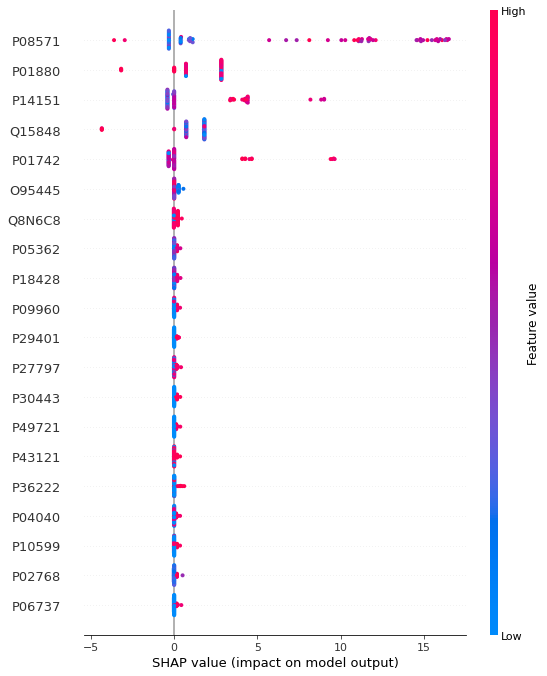

In [93]:
# XGBoost
from sklearn.ensemble import GradientBoostingClassifier

clf_GB = GradientBoostingClassifier(random_state=42)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scores = cross_val_score(clf_GB, X_scaled, y, cv=cv)
print("Gradient Boosting: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
explainer = shap.TreeExplainer(clf_GB.fit(df_X_scaled, y), df_X_scaled.iloc[:30, :])
shap_values = explainer(df_X_scaled)

shap.summary_plot(shap_values, df_X_scaled)


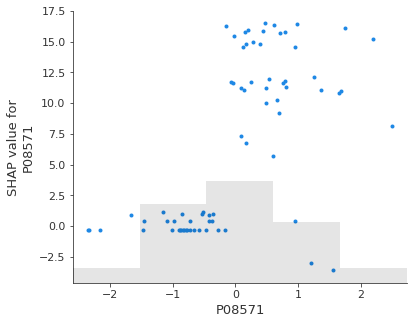

In [94]:
shap.plots.scatter(shap_values[:,'P08571'])

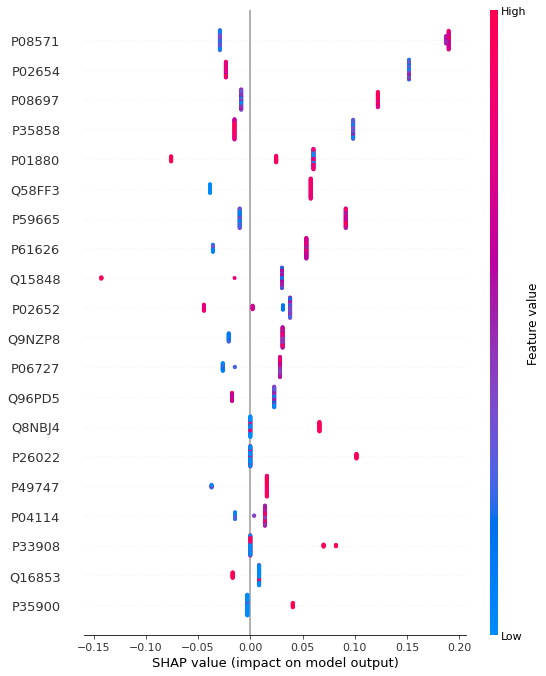

In [58]:
import xgboost
import shap

clf_xgb = xgboost.XGBRegressor(max_depth=1).fit(df_X_scaled, y)
explainer = shap.Explainer(clf_xgb, df_X_scaled.iloc[:30, :])
shap_values = explainer(df_X_scaled)

shap.summary_plot(shap_values, df_X_scaled)

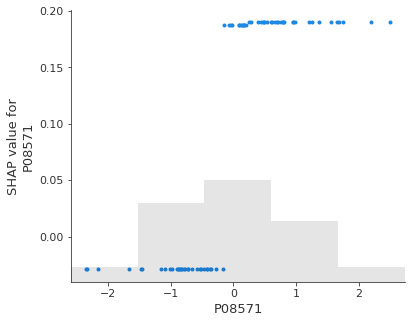

In [57]:
shap.plots.scatter(shap_values[:,'P08571'])

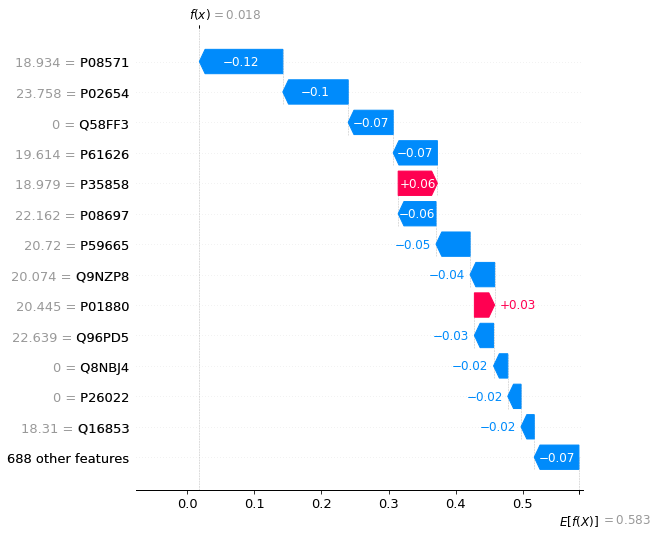

In [47]:
shap.plots.waterfall(shap_values[0], max_display=14)

In [88]:
# Simple NN
from tensorflow import keras
from tensorflow.keras import layers # the yellow underline is a bug

n_features = X.shape[1]
print(f"Number of features: {n_features}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training datapoints: {len(y_train)}. Testing datapoints: {len(y_test)}')

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_array = np.array(X_train_scaled)
y_array = np.array(y_train)-1

model = keras.Sequential([
    keras.layers.Dense(128, input_shape=(n_features,), activation='relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])

epochs = 3
batch_size = 10
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])


# use Shap-scores to remove proteins
# do some feature engineering to cut down amount of proteins
# leave one out and different feature engineering
print(model.summary())
res = model.fit(X_array, y_array, epochs=epochs, batch_size=batch_size)


Number of features: 701
Training datapoints: 57. Testing datapoints: 15
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 128)               89856     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 98,177
Trainable params: 98,177
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6/6 [==============================] - 0s 3ms/step - loss: 0.6265 - accuracy: 0.6491
Epoch 2/3
6/6 [==============================] - 0s 3ms/step - loss: 0.1726 - accuracy: 0.9825
Epoch 3/3
6/6 [==============================] 